In [1]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

username = 'Andrew_Reusche92'
api_key = '63cd28af853827307d2b6546dd833488'

api_token = {"username":username,"key":api_key}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json



In [2]:
!kaggle datasets download -d ronakgohil/license-plate-dataset

Dataset URL: https://www.kaggle.com/datasets/ronakgohil/license-plate-dataset
License(s): CC0-1.0


In [3]:
!unzip -q license-plate-dataset.zip -d data

In [11]:
pip install scikeras

In [13]:
#import some libraries that may be useful

import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasRegressor

In [17]:
#define the data path
base_path= 'data/archive'
train_img_path= os.path.join(base_path, 'images', 'train')
val_img_path= os.path.join(base_path, 'images', 'val')
train_label_path= os.path.join(base_path, 'labels', 'train')
val_label_path= os.path.join(base_path, 'labels', 'val')

In [20]:
#define the image size we want to transfrom all the image sizes to
img_size= 224 #pixels

In [21]:
#create function to load in the data
def load_data(img_folder, label_folder):
  images= []
  labels= []
  img_files= sorted([f for f in os.listdir(img_folder) if f.endswith('.jpg')])

  for img_file in img_files:

    #load image
    img_path= os.path.join(img_folder, img_file)
    img= cv2.imread(img_path)

    #change image color and shape
    img= cv2.resize(img, (img_size, img_size))
    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_height, img_width, _= img.shape

    #load labels
    label_file= img_file.replace('.jpg', '.txt')
    label_path= os.path.join(label_folder, label_file)
    if os.path.exists(label_path):
      with open(label_path, 'r') as f:

        #read in YOLO format
        line= f.readline().strip().split()

        if len(line) == 5:
          class_id, x_center, y_center, width, height= map(float, line)

          #convert YOLO to absolute pixel value
          x_center *= img_width
          y_center *= img_height
          width *= img_width
          height *= img_height

          #convert to coordinates
          x_min= x_center - (width/2)
          y_min= y_center - (height/2)
          x_max= x_center + (width/2)
          y_max= y_center + (height/2)

          #scale coordinates to resized image
          scale_x= img_size / img_width
          scale_y= img_size / img_height
          x_min *= scale_x
          y_min *= scale_y
          x_max *= scale_x
          y_max *= scale_y

          #add coordinates and images to lists
          labels.append([x_min, y_min, x_max, y_max])
          images.append(img)

  return np.array(images), np.array(labels)

In [22]:
#load in and split the data

#original training data
train_images, train_labels= load_data(train_img_path, train_label_path)
#validation data
val_images, val_labels= load_data(val_img_path, val_label_path)

#train-test-split the train to make a new test set from 10% of the original train
train_images, test_images, train_labels, test_labels= train_test_split(
    train_images,
    train_labels,
    test_size= 0.1,
    random_state= 24)

#print out the length of each new data subset
print(f'Training set: {len(train_images)} images')
print(f'Validation set: {len(val_images)} images')
print(f'Test set: {len(test_images)} images')

Training set: 1197 images
Validation set: 169 images
Test set: 134 images


## Data Exploration

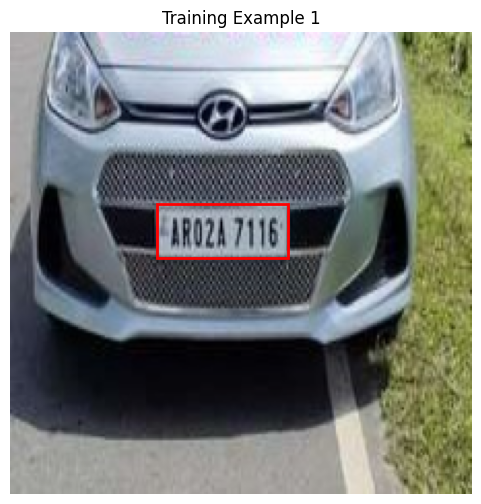

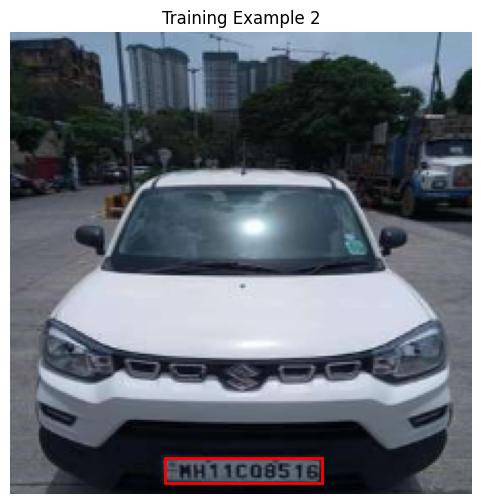

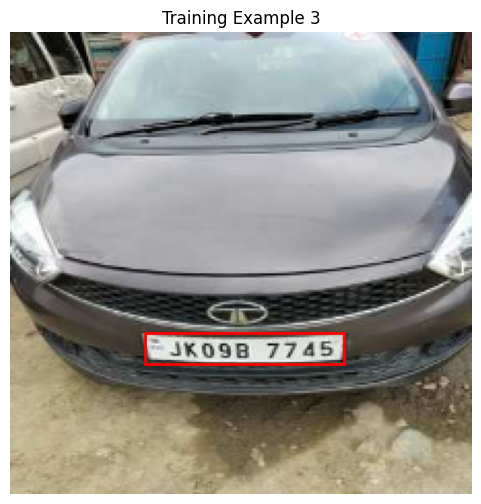

In [25]:
#function to plot training image with bounding box
def plot_image_with_bbox(image, bbox, title= 'image with bounding box'):
  plt.figure(figsize= (6,6))
  plt.imshow(image)
  x_min, y_min, x_max, y_max= bbox
  rect= plt.Rectangle((x_min, y_min),
                      x_max - x_min,
                      y_max - y_min,
                      linewidth= 2,
                      edgecolor= 'r',
                      facecolor= 'none')
  plt.gca().add_patch(rect)
  plt.title(title)
  plt.axis('off')
  plt.show()


  #plot the first three training examples
for i in range(3):
  plot_image_with_bbox(train_images[i],
                         train_labels[i],
                         title= f"Training Example {i+1}")